In [16]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from pymatgen.ext.matproj import MPRester
from pymatgen.core import Element, Composition
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter, PDEntry


In [17]:
unary_data = pickle.load(open("data_gather/unary_oxide_data_.p", "rb"))
binary_oxide_data = pickle.load(open("data_gather/binary_oxide_data_.p", "rb"))
ele2gs = pickle.load(open("data_gather/ele2gs.p", "rb"))

u_correction = {
    "V": -1.700,
    "Cr": -1.999,
    "Mn": -1.668,
    "Fe": -2.256,
    "Co": -1.638,
    "Ni": -2.541,
    "Mo": -3.202,
    "W": -4.438,
}

# define your reference materials project ids you want to compare, for now taking rutile if exists, or lowest
# octahedral MO2.
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-557057', # not rutile, 0.03 eV/atom lower
    'Ni': 'mp-35925', # layered Ni
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-1205429', # this is lowest FeO2, suspect rutile in MP is wrong magmoms
    'Mn': 'mp-19395', # many morphologiesi close to eachother, rutile 0.03 eV/atom
    'Co': 'mvc-14149', # layered Co mp-1272749 octahedral
    'Pb': 'mp-20725',
    'Sb': 'mvc-5581',#mp-230 omst stable, # mvc-5581 was chosen since it is 0.17 eV/atom more unstable than the most stable MP SbO2 (this is chosen because OQMD has this difference for its rutile SbO2)
    'Sn': 'mp-856',
    'Bi': 'mp-557993',#mp-557993 not rutile
    'Ti': 'mp-390',
    'Ta': 'mp-510', #mp-20994 rutile, 0.02 eV/atom higher
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',# not rutile
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
    'Cu': 'mp-25378',
    'Te': 'mp-2125', # mp-2237 rutile, 0.25 eV/atom higher, icsd
    'Li': 'mp-1018789',
    'Na': 'mp-1901',
    'Ca': 'mp-634859',
    'K': 'mp-1866',
    'Rb': 'mp-12105',
    'Cs': 'mp-1441',
    'Mg': 'mp-2589',
    'Y': 'mp-1206610',
    'Sc': 'mp-1179114',
    'Ba': 'mp-1105',
    'Zn': 'mp-1094003',
    'La': 'mp-1206559',
    'Ce': 'mp-20194',
    'Pr': 'mp-1302',
    'Nd': 'mp-31049',
    'Sm': 'mp-1077235',
    'Eu': 'mp-1018700',
    'Tb': 'mp-2458',
    'Dy': 'mp-1206731',
    #'Ho': 'mp-1206243',
    'Er': 'mp-1206338',
    'Tm': 'mp-1206313',
    'Yb': 'mp-1178667'
}


d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni'],
    '4': ['Nb', 'Mo', ],
    '5': ['Ta', 'W', ]
}


# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ge": "g",
    "Rh": "#FFA500",
    "Sb": "#66ff00",
    "Te": "y",
    "Ir": "b",
    "Ni": "#66FF00",
    "Bi": "b",
    'Sr': '#A020F0',
    'Ru': 'y',
    'Ta': '#8b0000',
    'In': '#a9a9a9',
    'Pt': 'gray',
    'Pd': 'orange',
    'Re': 'purple',
    'Os': 'brown',
    'Tc': 'indigo',
    'Pb': '#4169e1',
    'Rh': 'cyan',
    'Li': 'cyan',
    'Mg': 'orange',
    'K': 'purple',
    'Na': 'g',
    "La": "#808080",
    "Ce": "#ffcccb",
    "Pr": "k",
    "Nd": "g",
    "Pm": "r",
    "Sm": "b",
    "Eu": "#FFFF00",
    "Gd": "cyan",
    "Tb": "#FFA500",
    "Dy": "k",
    "Ho": "fuchsia",
    "Er": "g",
    "Tm": "#FFA500",
#    "Yb": "#66ff00",
    "Lu": "y",
    'Zn': 'gray'
} 


oqmd_quadratic_equations_ox = pickle.load(open('make_quadratics/oqmd_quadratic_equations_ox.p', 'rb'))
oqmd_quadratic_equations_red = pickle.load(open('make_quadratics/oqmd_quadratic_equations_red.p', 'rb'))

mp_quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
mp_quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))


potential_hosts = ['Ag', 'Ge', 'Bi', 'Co', 'Ir', 'Nb', 'Pb', 'Pd', 'Pt', 'Rh',
                  'Ru', 'Sb', 'Si', 'Sn', 'Ta', 'Te', 'Ti', 'Tl', 'W']
abundant_hosts = ['Bi', 'Co','Nb', 'Pb', 'Sb', 'Sn', 'Ta', 'Ti', 'Tl', 'W']



In [39]:
def get_ref_data(element, reference_oxide_id):
    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            ref_fingerprint = unary_data[element]['fingerprints'][idx]
            ref_struct = unary_data[element]['structures'][idx]
            ref_ene = unary_data[element]['energies'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            #print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene, ref_fingerprint, ref_struct


def uncorr_ene_from_formation_energy(formation_energy_correction, ele1, ele2, ele1_conc, o_conc):
    """
    Return the synthetically calculated uncorrected DFT energy given a formation energy correction with
    respect to the reference oxides.
    """
    o_energy = -4.948
    o_correction = -0.687
    ele1_ene, ele1_fingerprint, ele1_struct = get_ref_data(ele1, ele2mp[ele1])
    ele2_ene, ele2_fingerprint, ele2_struct = get_ref_data(ele2, ele2mp[ele2])
    
    total_form_ene = ele1_ene*ele1_conc+ele2_ene*(1-ele1_conc)+formation_energy_correction
    end_member_ene = (1-o_conc)*(ele1_conc*ele2gs[ele1]+(1-ele1_conc)*ele2gs[ele2])+(o_conc)*(o_energy)
    corrections = o_conc*(o_correction)
    # now get the corrections that would be applied per atom
    if ele1 in u_correction.keys():
        corrections += (1-o_conc)*(ele1_conc*u_correction[ele1])
    if ele2 in u_correction.keys():
        corrections += (1-o_conc)*((1-ele1_conc)*u_correction[ele2])
    # by definition formation energy = (mixed system energy) - (end member energy), here we just manipulate
    # that equation and remove the MP corrections.
    uncorr_energy = total_form_ene+end_member_ene
    return uncorr_energy 


def make_synthetic_mp(energy_correction, ele1, ele2, ele1_conc, o_conc):
    name = "{}{}{}{}O{}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    composition = Composition(name)
    label = "{}{:.3f}{}{:.3f}O{:.3f}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    energy = uncorr_ene_from_formation_energy(energy_correction, ele1, ele2, ele1_conc, o_conc)
    return PDEntry(composition, energy, name=name), label


def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os



def get_conc_in_binary(structure, element):
    element_count = 0
    other_element_count = 0
    for site in structure.sites:
        if str(site.specie)==element:
            element_count+=1
        elif str(site.specie)=='O':
            continue
        else:
            other_element_count+=1
    return element_count/(element_count+other_element_count)


def get_binary_mp_data(element1, element2):
    pairings = []
    found_key = False
    for key in binary_oxide_data.keys():
        if element1 in key and element2 in key:
            # the order of the elements is arbitrary, depends how the data was gathered
            needed_key = key
            found_key = True
    if not found_key:
        print("No data for combination: {}, {}".format(element1, element2))
        return 
    
    conc2lowest = defaultdict()
    lowest_ene = 0 
    for idx, struct in enumerate(binary_oxide_data[needed_key]['structures']):
        m_coords, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==4 and list(set(m_coords))==[6]:
            # then we care about this structure to make comparisons
            dope_conc = get_conc_in_binary(struct, element2)
            #print(dope_conc)
            #print(binary_oxide_data['{}_Sb'.format(dope_element)]['names'][idx])
            mixed_energy = binary_oxide_data[needed_key]['formation_energies'][idx]
            dope_o2_ene, dope_o2_fingerprint, dope_o2_struct = get_ref_data(element2, ele2mp[element2])
            sbo2_ene, sbo2_fingerprint, sbo2_struct = get_ref_data(element1, ele2mp[element1])
            ##if element2=='Ni':
             #   dope_o2_ene+=0.05
            mixing_stabilisation = mixed_energy - (dope_o2_ene*dope_conc+(sbo2_ene)*(1-dope_conc))
            pairings.append((dope_conc, mixing_stabilisation, element2))
            gs_key = element2+"_{:.2f}".format(dope_conc)
            if gs_key not in conc2lowest:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation)
            elif conc2lowest[gs_key][1]>mixing_stabilisation:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation)
    return pairings, conc2lowest


def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = quadratic_equations_ox[ele1]
    ox_quadratic_2 = quadratic_equations_ox[ele2]
    red_quadratic_1 = quadratic_equations_red[ele2]
    red_quadratic_2 = quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, o_3a, r_1a, r_2a, r_3a, True), bounds=[(0, 3)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, o_3b, r_1b, r_2b, r_3b, True), bounds=[(0, conc/(1-conc))])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, o_3a, r_1a, r_2a, r_3a),  bounds=[(0, 3)])
            # Note, the definition of concentration is different  between 1/2, handle this when plotting 
            # by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, o_3b, r_1b, r_2b, r_3b),  bounds=[(0, 3)])#10*upper_bound+0.01)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        predicted_forms_1.append(result_1.fun[0])
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun[0])#result_2.fun[0] + diff*(1-conc))
        
        mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
        ox1 = o_1a*x_space**2+o_2a*x_space
        red1 = r_1a*x_space**2+r_2a*x_space

        
        mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        if conc==0 or conc==1:
            continue

    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, o3, r1, r2, r3, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))



In [40]:
quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))


oqmd_quadratic_equations_ox = pickle.load(open('make_quadratics/oqmd_quadratic_equations_ox.p', 'rb'))
oqmd_quadratic_equations_red = pickle.load(open('make_quadratics/oqmd_quadratic_equations_red.p', 'rb'))

# handle the 'needs to be done differently' or 'WARNING! Adding an end member'
# by setting those curves to the oqmd curves, if they didn't give the same issue
quadratic_equations_ox['Ru'] = oqmd_quadratic_equations_ox['Ru']
quadratic_equations_ox['Sn'] = oqmd_quadratic_equations_ox['Sn']
quadratic_equations_ox['Ir'] = oqmd_quadratic_equations_ox['Ir']
quadratic_equations_red['Sn'] = oqmd_quadratic_equations_red['Sn']
quadratic_equations_ox['Pb'] = oqmd_quadratic_equations_ox['Pb']
quadratic_equations_red['Pb'] = oqmd_quadratic_equations_red['Pb']
quadratic_equations_ox['Cr'] = oqmd_quadratic_equations_ox['Cr']

# Cr curve does not fit through Cr2O3 
#quadratic_equations_red['Cr'] = oqmd_quadratic_equations_red['Cr']

# handle any wrongly shaped curves
for ele in set(list(quadratic_equations_ox.keys())+list(quadratic_equations_red.keys())):
    if quadratic_equations_ox[ele][0]<0 and ele in oqmd_quadratic_equations_ox.keys():
        print("Replacing oxidising eq for {}".format(ele))
        print(quadratic_equations_ox[ele][0])
        print(oqmd_quadratic_equations_ox[ele])
        quadratic_equations_ox[ele] = oqmd_quadratic_equations_ox[ele]
    if quadratic_equations_red[ele][0]<0 and ele in oqmd_quadratic_equations_red.keys():
        print("Replacing reducing eq for {}".format(ele))
        print(quadratic_equations_red[ele][0])
        print(oqmd_quadratic_equations_red[ele])
        quadratic_equations_red[ele] = oqmd_quadratic_equations_red[ele]

Replacing oxidising eq for Mn
-0.15011627650137807
[2.40250000e-02 9.61000000e-02 1.96261557e-17]
Replacing oxidising eq for Fe
-0.21650603824761877
[0.0190125 0.07605   0.       ]


Ti
V
Cr
Mn
Fe
Co
Ni


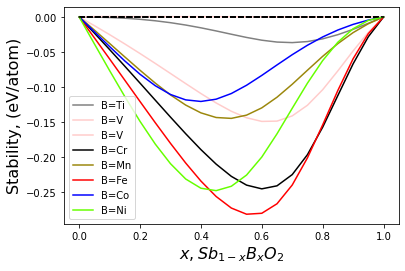

In [42]:

for housing_element in ['Sb']:
    if (housing_element not in mp_quadratic_equations_ox.keys() or housing_element not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    concs = np.linspace(0, 1.00, 21)

    for ele in d2metals['3']:
        print(ele)
        if ele==housing_element:# or ele in d2metals['3']+['Mo', 'Nb', 'W']:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(ele, housing_element,
                                                                 concs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(concs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([concs[0], concs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(concs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([concs[0], concs[-1]], [0, 0], 'k--')
    
    plt.legend()
    plt.xlabel("$x, {}_{{1-x}}B_{{x}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("Stability, (eV/atom)", fontsize=16)
    #plt.ylim(-0.1, 0.1)
    #plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

In [38]:
quadratic_equations_red['Sn']

array([0.16425595, 0.026649  , 0.00587832])